In [1]:
import os

import pandas as pd, numpy as np, seaborn as sns
import math, json
from matplotlib import pyplot as plt
from tqdm import tqdm

from sklearn.model_selection import train_test_split, KFold

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Import Data

In [2]:
train = pd.read_pickle('/home/azureuser/cloudfiles/code/Users/kuan.pang/mrna/train.pkl')

test = pd.read_pickle('/home/azureuser/cloudfiles/code/Users/kuan.pang/mrna/test.pkl')


In [3]:
train.head()

,index,id,sequence,structure,predicted_loop_type,signal_to_noise,SN_filter,seq_length,seq_scored,reactivity_error,...,deg_error_pH10,deg_error_Mg_50C,deg_error_50C,reactivity,deg_Mg_pH10,deg_pH10,deg_Mg_50C,deg_50C,bpps_sum,bpps_max
0,0,id_001f94081,GGAAAAGCUCUAAUAACAGGAGACUAGGACUACGUAUUUCUAGGUA...,.....((((((.......)))).)).((.....((..((((((......,EEEEESSSSSSHHHHHHHSSSSBSSXSSIIIIISSIISSSSSSHHH...,6.894,1,107,68,"[0.1359, 0.20700000000000002, 0.1633, 0.1452, ...",...,"[0.2631, 0.28600000000000003, 0.0964, 0.1574, ...","[0.1501, 0.275, 0.0947, 0.18660000000000002, 0...","[0.2167, 0.34750000000000003, 0.188, 0.2124, 0...","[0.3297, 1.5693000000000001, 1.1227, 0.8686, 0...","[0.7556, 2.983, 0.2526, 1.3789, 0.637600000000...","[2.3375, 3.5060000000000002, 0.3008, 1.0108, 0...","[0.35810000000000003, 2.9683, 0.2589, 1.4552, ...","[0.6382, 3.4773, 0.9988, 1.3228, 0.78770000000...","[0.0217857, 0.0386527, 0.0275904, 0.00947066, ...","[0.19854229, 0.18371220000000002, 0.0600024000..."
1,1,id_0049f53ba,GGAAAAAGCGCGCGCGGUUAGCGCGCGCUUUUGCGCGCGCUGUACC...,.....(((((((((((((((((((((((....)))))))))).)))...,EEEEESSSSSSSSSSSSSSSSSSSSSSSHHHHSSSSSSSSSSBSSS...,0.193,0,107,68,"[2.8272, 2.8272, 2.8272, 4.7343, 2.5676, 2.567...",...,"[10.1986, 9.2418, 5.0933, 5.0933, 5.0933, 5.09...","[16.6174, 13.868, 8.1968, 8.1968, 8.1968, 8.19...","[15.4857, 7.9596, 13.3957, 5.8777, 5.8777, 5.8...","[0.0, 0.0, 0.0, 2.2965, 0.0, 0.0, 0.0, 0.0, 0....","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[4.947, 4.4523, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[4.8511, 4.0426, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[7.6692, 0.0, 10.9561, 0.0, 0.0, 0.0, 0.0, 0.0...","[0.11931483477784201, 0.0808186531761711, 0.06...","[0.16883627604054915, 0.10675940059456464, 0.0..."
2,2,id_006f36f57,GGAAAGUGCUCAGAUAAGCUAAGCUCGAAUAGCAAUCGAAUAGAAU...,.....((((.((.....((((.(((.....)))..((((......)...,EEEEESSSSISSIIIIISSSSMSSSHHHHHSSSMMSSSSHHHHHHS...,8.800,1,107,68,"[0.0931, 0.13290000000000002, 0.11280000000000...",...,"[0.17020000000000002, 0.178, 0.111, 0.091, 0.0...","[0.1033, 0.1464, 0.1126, 0.09620000000000001, ...","[0.14980000000000002, 0.1761, 0.1517, 0.116700...","[0.44820000000000004, 1.4822, 1.1819, 0.743400...","[0.2504, 1.4021, 0.9804, 0.49670000000000003, ...","[2.243, 2.9361, 1.0553, 0.721, 0.6396000000000...","[0.5163, 1.6823000000000001, 1.0426, 0.7902, 0...","[0.9501000000000001, 1.7974999999999999, 1.499...","[0.017340043515196805, 0.00826566577930985, 0....","[0.06680724164624499, 0.04433748694733778, 0.0..."
3,3,id_0082d463b,GGAAAAGCGCGCGCGCGCGCGCGAAAAAGCGCGCGCGCGCGCGCGC...,......((((((((((((((((......))))))))))))))))((...,EEEEEESSSSSSSSSSSSSSSSHHHHHHSSSSSSSSSSSSSSSSSS...,0.104,0,107,68,"[3.5229, 6.0748, 3.0374, 3.0374, 3.0374, 3.037...",...,"[11.8007, 12.7566, 5.7733, 5.7733, 5.7733, 5.7...","[121286.7181, 121286.7182, 121286.7181, 121286...","[15.3995, 8.1124, 7.7824, 7.7824, 7.7824, 7.78...","[0.0, 2.2399, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0....","[0.0, -0.5083, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0...","[3.4248, 6.8128, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[0.0, -0.8365, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0...","[7.6692, -1.3223, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0...","[0.0350158, 0.0332295, 0.00272567, 0.0, 0.0, 0...","[0.22702912000000003, 0.18439387000000002, 0.0..."
4,4,id_0087940f4,GGAAAAUAUAUAAUAUAUUAUAUAAAUAUAUUAUAGAAGUAUAAUA...,.....(((((((.((((((((((((.(((((((((....)))))))...,EEEEESSSSSSSBSSSSSSSSSSSSBSSSSSSSSSHHHHSSSSSSS...,0.423,0,107,68,"[1.665, 2.1728, 2.0041, 1.2405, 0.620200000000...",...,"[3.0942, 3.015, 2.1212, 2.0552, 0.881500000000...","[2.6717, 2.4818, 1.9919, 2.5484999999999998, 1...","[1.3285, 3.6173, 1.3057, 1.3021, 1.1507, 1.150...","[0.8267, 2.6577, 2.8481, 0.40090000000000003, ...","[2.1058, 3.138, 2.5437000000000003, 1.0932, 0....","[4.7366, 4.6243, 1.2068, 1.1538, 0.0, 0.0, 0.7...","[2.2052, 1.7947000000000002, 0.7457, 3.1233, 0...","[0.0, 5.1198, -0.3551, -0.3518, 0.0, 0.0, 0.0,...","[0.02230060114516417, 0.052274223411953764, 0....","[0.04036075455181073, 0.0802

## Pre-process

In [4]:
target_cols = ['reactivity', 'deg_Mg_pH10', 'deg_pH10', 'deg_Mg_50C', 'deg_50C']

In [5]:
token2int = {x:i for i, x in enumerate('(.)ACGUBEHIMSX')} #OHE

In [6]:
def reverse_input(train_input):
    reverse = train_input[:, ::-1, :]
    return reverse #Reverse sequence


def preprocess_inputs(df, cols=['sequence', 'structure', 'predicted_loop_type']):
    base_feature =  np.transpose(
        np.array(
            df[cols]
            .applymap(lambda seq: [token2int[x] for x in seq])
            .values
            .tolist()
        ),
        (0, 2, 1)
    )
    
    bpps_sum_fea = np.array(df['bpps_sum'].to_list())[:,:,np.newaxis]
    bpps_max_fea = np.array(df['bpps_max'].to_list())[:,:,np.newaxis]

    return  np.concatenate([base_feature, bpps_sum_fea,bpps_max_fea], 2) #Aggregate BBP results
                              

def argument(array):
    return np.concatenate([array,reverse_input(array)], axis=0) #Apply agumentation




## Training and Inference

In [7]:
INDEX_BASE = torch.tensor([0, 1, 2]).to(device) #Base feature index
INDEZ_BPP = torch.tensor([3, 4]).to(device)  #Extarcte  feature index



class GRU_model(nn.Module):
    def __init__(
        self, seq_len=107, pred_len=68, dropout=0.5, embed_dim=100, hidden_dim=128, hidden_layers=3
    ):
        super(GRU_model, self).__init__()
        self.pred_len = pred_len

        self.embeding = nn.Embedding(num_embeddings=len(token2int), embedding_dim=embed_dim)
        self.gru = nn.GRU(
            input_size=embed_dim * 3 + 2,
            hidden_size=hidden_dim,
            num_layers=hidden_layers,
            dropout=dropout,
            bidirectional=True,
            batch_first=True,
        )
        self.linear = nn.Linear(hidden_dim * 2, 5)

    def forward(self, seqs):
        embed = self.embeding(seqs.index_select(2, INDEX_BASE).long())
        reshaped = torch.reshape(embed, (-1, embed.shape[1], embed.shape[2] * embed.shape[3]))
        reshaped = torch.cat([reshaped, seqs.index_select(2, INDEZ_BPP)], dim=2).float()
        output, hidden = self.gru(reshaped)
        truncated = output[:, : self.pred_len, :]
        out = self.linear(truncated)
        return out
    
class LSTM_model(nn.Module):
    def __init__(
        self, seq_len=107, pred_len=68, dropout=0.5, embed_dim=100, hidden_dim=128, hidden_layers=3
    ):
        super(LSTM_model, self).__init__()
        self.pred_len = pred_len

        self.embeding = nn.Embedding(num_embeddings=len(token2int), embedding_dim=embed_dim)
        self.gru = nn.LSTM(
            input_size=embed_dim * 3 + 2,
            hidden_size=hidden_dim,
            num_layers=hidden_layers,
            dropout=dropout,
            bidirectional=True,
            batch_first=True,
        )
        self.linear = nn.Linear(hidden_dim * 2, 5)

    def forward(self, seqs):
        embed = self.embeding(seqs.index_select(2, INDEX_BASE).long())
        reshaped = torch.reshape(embed, (-1, embed.shape[1], embed.shape[2] * embed.shape[3]))
        reshaped = torch.cat([reshaped, seqs.index_select(2, INDEZ_BPP)], dim=2).float()
        output, hidden = self.gru(reshaped)
        truncated = output[:, : self.pred_len, :]
        out = self.linear(truncated)
        return out


def MCRMSE(y_true, y_pred):
    #MCRMSE loss fucntion
    
    colwise_mse = torch.mean(torch.square(y_true - y_pred), dim=1)
    
    
    return torch.mean(torch.sqrt(colwise_mse), dim=1)


def compute_loss(batch_X, batch_Y, model, optimizer=None, is_train=True):
    model.train(is_train)
    

    pred_Y = model(batch_X)

    
        
    loss = MCRMSE(pred_Y, batch_Y).mean()
    


    if is_train:
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    return loss.item()

In [8]:
FOLDS = 4
EPOCHS = 80
BATCH_SIZE = 64
VERBOSE = 2
LR = 0.01


public_df = test.query("seq_length == 107").copy()
private_df = test.query("seq_length == 130").copy()

public_inputs = torch.tensor(preprocess_inputs(public_df)).to(device)
private_inputs = torch.tensor(preprocess_inputs(private_df)).to(device)

public_loader = DataLoader(TensorDataset(public_inputs), shuffle=False, batch_size=BATCH_SIZE)
private_loader = DataLoader(TensorDataset(private_inputs), shuffle=False, batch_size=BATCH_SIZE)



train_filtered = train.loc[train.SN_filter == 1]
train_inputs = torch.tensor(argument(preprocess_inputs(train_filtered))).to(device)
train_labels = torch.tensor(
    argument(np.array(train_filtered[target_cols].values.tolist()).transpose(0, 2, 1))
).float().to(device)

In [9]:
gru_histories = []
gru_private_preds = np.zeros((private_df.shape[0], 130, 5))
gru_public_preds = np.zeros((public_df.shape[0], 107, 5))

kfold = KFold(FOLDS, shuffle=True, random_state=2020)

for k, (train_index, val_index) in enumerate(kfold.split(train_inputs)):
    train_dataset = TensorDataset(train_inputs[train_index], train_labels[train_index])
    val_dataset = TensorDataset(train_inputs[val_index], train_labels[val_index])

    train_loader = DataLoader(train_dataset, shuffle=True, batch_size=BATCH_SIZE)
    val_loader = DataLoader(val_dataset, shuffle=False, batch_size=BATCH_SIZE)

    model = GRU_model().to(device)
    optimizer = optim.Adam(model.parameters(), lr=LR)

    train_losses = []
    val_losses = []
    for epoch in tqdm(range(EPOCHS)):
        train_losses_batch = []
        val_losses_batch = []
        for (batch_X, batch_Y) in train_loader:
            train_loss = compute_loss(batch_X, batch_Y, model, optimizer=optimizer, is_train=True)
            train_losses_batch.append(train_loss)
        for (batch_X, batch_Y) in val_loader:
            val_loss = compute_loss(batch_X, batch_Y, model, optimizer=optimizer, is_train=False)
            val_losses_batch.append(val_loss)
        train_losses.append(sum(train_losses_batch) / len(train_losses_batch))
        val_losses.append(sum(val_losses_batch) / len(val_losses_batch))
        

        
        
    model_state = model.state_dict()
    del model
            
    gru_histories.append({'train_loss': train_losses, 'val_loss': val_losses})


    gru_short = GRU_model(seq_len=107, pred_len=107).to(device)
    gru_short.load_state_dict(model_state)
    gru_short.eval()
    gru_public_pred = np.ndarray((0, 107, 5))
    for batch in public_loader:
        batch_X = batch[0]
        pred = gru_short(batch_X).detach().cpu().numpy()
        gru_public_pred = np.concatenate([gru_public_pred, pred], axis=0)
    gru_public_preds += gru_public_pred / FOLDS

    gru_long = GRU_model(seq_len=130, pred_len=130).to(device)
    gru_long.load_state_dict(model_state)
    gru_long.eval()
    gru_private_pred = np.ndarray((0, 130, 5))
    for batch in private_loader:
        batch_X = batch[0]
        pred = gru_long(batch_X).detach().cpu().numpy()
        gru_private_pred = np.concatenate([gru_private_pred, pred], axis=0)
    gru_private_preds += gru_private_pred / FOLDS
    
    del gru_short, gru_long

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 80/80 [03:35<00:00,  2.69s/it]


In [10]:
print(f" GRU mean fold validation loss: {np.mean([min(history['val_loss']) for history in gru_histories])}")

 GRU mean fold validation loss: 0.2992305425660951


In [11]:
lstm_histories = []
lstm_private_preds = np.zeros((private_df.shape[0], 130, 5))
lstm_public_preds = np.zeros((public_df.shape[0], 107, 5))

kfold = KFold(FOLDS, shuffle=True, random_state=2020)

for k, (train_index, val_index) in enumerate(kfold.split(train_inputs)):
    train_dataset = TensorDataset(train_inputs[train_index], train_labels[train_index])
    val_dataset = TensorDataset(train_inputs[val_index], train_labels[val_index])

    train_loader = DataLoader(train_dataset, shuffle=True, batch_size=BATCH_SIZE)
    val_loader = DataLoader(val_dataset, shuffle=False, batch_size=BATCH_SIZE)

    model = LSTM_model().to(device)
    optimizer = optim.Adam(model.parameters(), lr=LR)

    train_losses = []
    val_losses = []
    for epoch in tqdm(range(EPOCHS)):
        train_losses_batch = []
        val_losses_batch = []
        for (batch_X, batch_Y) in train_loader:
            train_loss = compute_loss(batch_X, batch_Y, model, optimizer=optimizer, is_train=True)
            train_losses_batch.append(train_loss)
        for (batch_X, batch_Y) in val_loader:
            val_loss = compute_loss(batch_X, batch_Y, model, optimizer=optimizer, is_train=False)
            val_losses_batch.append(val_loss)
        train_losses.append(sum(train_losses_batch) / len(train_losses_batch))
        val_losses.append(sum(val_losses_batch) / len(val_losses_batch))
    model_state = model.state_dict()
    del model
            
    lstm_histories.append({'train_loss': train_losses, 'val_loss': val_losses})


    lstm_short = LSTM_model(seq_len=107, pred_len=107).to(device)
    lstm_short.load_state_dict(model_state)
    lstm_short.eval()
    lstm_public_pred = np.ndarray((0, 107, 5))
    for batch in public_loader:
        batch_X = batch[0]
        pred = lstm_short(batch_X).detach().cpu().numpy()
        lstm_public_pred = np.concatenate([lstm_public_pred, pred], axis=0)
    lstm_public_preds += lstm_public_pred / FOLDS

    lstm_long = LSTM_model(seq_len=130, pred_len=130).to(device)
    lstm_long.load_state_dict(model_state)
    lstm_long.eval()
    lstm_private_pred = np.ndarray((0, 130, 5))
    for batch in private_loader:
        batch_X = batch[0]
        pred = lstm_long(batch_X).detach().cpu().numpy()
        lstm_private_pred = np.concatenate([lstm_private_pred, pred], axis=0)
    lstm_private_preds += lstm_private_pred / FOLDS
    
    del lstm_short, lstm_long

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 80/80 [03:44<00:00,  2.81s/it]


In [12]:
print(f" LSTM mean fold validation loss: {np.mean([min(history['val_loss']) for history in lstm_histories])}")

 LSTM mean fold validation loss: 0.21757924237421583


Text(0.5, 0, 'Epoch')

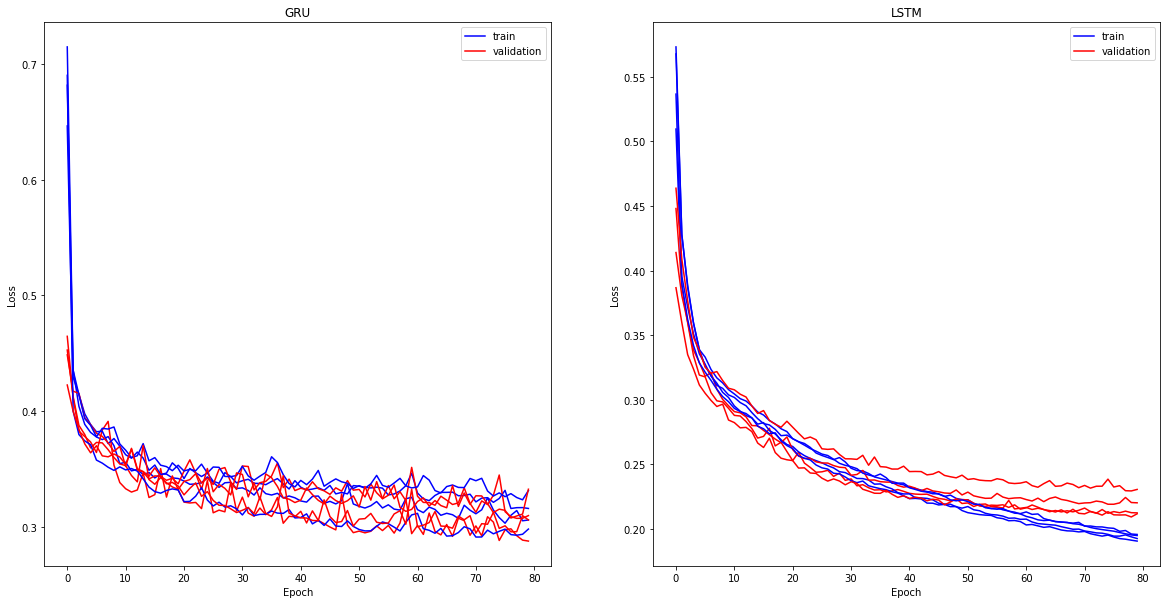

In [13]:
fig, ax = plt.subplots(1, 2, figsize = (20, 10))

for history in gru_histories:
    ax[0].plot(history['train_loss'], 'b')
    ax[0].plot(history['val_loss'], 'r')
for history in lstm_histories:
    ax[1].plot(history['train_loss'], 'b')
    ax[1].plot(history['val_loss'], 'r')

ax[0].set_title('GRU')
ax[1].set_title('LSTM')

ax[0].legend(['train', 'validation'], loc = 'upper right')
ax[1].legend(['train', 'validation'], loc = 'upper right')

ax[0].set_ylabel('Loss')
ax[0].set_xlabel('Epoch')
ax[1].set_ylabel('Loss')
ax[1].set_xlabel('Epoch')

## Post-process

In [14]:
public_df = test.query("seq_length == 107").copy()
private_df = test.query("seq_length == 130").copy()

public_inputs = preprocess_inputs(public_df)
private_inputs = preprocess_inputs(private_df)


preds_gru = []

for df, preds in [(public_df, gru_public_preds), (private_df, gru_private_preds)]:
    for i, uid in enumerate(df.id):
        single_pred = preds[i]

        single_df = pd.DataFrame(single_pred, columns=target_cols)
        single_df['id_seqpos'] = [f'{uid}_{x}' for x in range(single_df.shape[0])]

        preds_gru.append(single_df)

preds_gru_df = pd.concat(preds_gru)
preds_gru_df.head()

,reactivity,deg_Mg_pH10,deg_pH10,deg_Mg_50C,deg_50C,id_seqpos
0,0.661433,0.675995,2.102352,0.559472,0.677884,id_00073f8be_0
1,2.046901,2.988447,3.889023,2.915509,2.394129,id_00073f8be_1
2,1.221250,0.670286,0.915967,1.000070,0.997354,id_00073f8be_2
3,1.086687,0.904059,0.981549,1.160169,1.011882,id_00073f8be_3
4,0.889140,0.652817,0.793830,0.895096,0.829818,id_00073f8be_4


In [15]:
preds_lstm = []

for df, preds in [(public_df, lstm_public_preds), (private_df, lstm_private_preds)]:
    for i, uid in enumerate(df.id):
        single_pred = preds[i]

        single_df = pd.DataFrame(single_pred, columns=target_cols)
        single_df['id_seqpos'] = [f'{uid}_{x}' for x in range(single_df.shape[0])]

        preds_lstm.append(single_df)

preds_lstm_df = pd.concat(preds_lstm)
preds_lstm_df.head()

,reactivity,deg_Mg_pH10,deg_pH10,deg_Mg_50C,deg_50C,id_seqpos
0,0.883519,0.773838,2.115986,0.593780,0.782004,id_00073f8be_0
1,2.744516,3.673347,4.984481,3.602574,3.077330,id_00073f8be_1
2,1.729191,0.695886,0.825364,0.737828,0.763947,id_00073f8be_2
3,1.480409,1.307533,1.484450,1.798064,1.690295,id_00073f8be_3
4,0.926277,0.702236,0.756782,0.984487,0.907289,id_00073f8be_4


In [16]:
blend_preds_df = pd.DataFrame()
blend_preds_df['id_seqpos'] = preds_gru_df['id_seqpos']
blend_preds_df['reactivity'] = .5*preds_gru_df['reactivity'] + .5*preds_lstm_df['reactivity']
blend_preds_df['deg_Mg_pH10'] = .5*preds_gru_df['deg_Mg_pH10'] + .5*preds_lstm_df['deg_Mg_pH10']
blend_preds_df['deg_pH10'] = .5*preds_gru_df['deg_pH10'] + .5*preds_lstm_df['deg_pH10']
blend_preds_df['deg_Mg_50C'] = .5*preds_gru_df['deg_Mg_50C'] + .5*preds_lstm_df['deg_Mg_50C']
blend_preds_df['deg_50C'] = .5*preds_gru_df['deg_50C'] + .5*preds_lstm_df['deg_50C']

In [17]:
sample_sub = pd.read_csv('/home/azureuser/cloudfiles/code/Users/kuan.pang/mrna/sample_submission.csv')


submission = sample_sub[['id_seqpos']].merge(blend_preds_df, on=['id_seqpos'])

submission.head()

,id_seqpos,reactivity,deg_Mg_pH10,deg_pH10,deg_Mg_50C,deg_50C
0,id_00073f8be_0,0.772476,0.724917,2.109169,0.576626,0.729944
1,id_00073f8be_1,2.395708,3.330897,4.436752,3.259041,2.735729
2,id_00073f8be_2,1.475221,0.683086,0.870665,0.868949,0.880650
3,id_00073f8be_3,1.283548,1.105796,1.233000,1.479116,1.351088
4,id_00073f8be_4,0.907709,0.677526,0.775306,0.939792,0.868554


In [19]:
submission.to_csv('/home/azureuser/cloudfiles/code/Users/kuan.pang/mrna/sample_submission.csv', index=False)
print('final prediction saved')

final prediction saved
